In [21]:
import os

import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import time

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn import svm
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
df = pd.read_csv('./preprocessed_apartment.csv')
df.head()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
0,8,1,1156,1504,196.21,450000.0,13.0,211.23,1976.06,480.0,120.0,7582.0,7043.0,2018,12
1,8,1,1706,4942,202.58,450000.0,5.0,252.31,2010.07,19.0,1.0,7343.0,5896.0,2018,12
2,8,1,1156,9746,139.83,320000.0,7.0,165.29,1982.04,1924.0,168.0,7565.0,6400.0,2018,12
3,8,1,393,15322,191.04,315000.0,2.0,219.22,1983.12,1204.0,84.0,5451.0,4750.0,2018,12
4,8,1,1156,1509,144.20,304000.0,10.0,158.68,1979.05,560.0,168.0,6969.0,6333.0,2018,12


In [3]:
df.shape

(6174900, 15)

In [4]:
# df_down1 = df.sample(n=600000)
# print(df_down1.shape)
# df_down1.head()

In [5]:
# df_down2 = df.sample(n=15000)
# print(df_down2.shape)
# df_down2.head()

In [6]:
# df_down3 = df.sample(n=1000)
# print(df_down3.shape)
# df_down3.head()

In [7]:
# df_down4 = df.sample(n=100)
# print(df_down4.shape)
# df_down4.head()

In [8]:
y = df['price']
del df['price']

In [9]:
x_train, x_test,y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

# 4 ML models

In [10]:
gboost = GradientBoostingRegressor(random_state=0)
xgboost = xgb.XGBRegressor(random_state=0)
lightgbm = lgb.LGBMRegressor(random_state=0)
lasso = Lasso(alpha=1.0, random_state=0)
svm = svm.SVC(kernel='rbf', C=1, gamma=0.1, random_state=0)

models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':gboost, 'name': 'GradientBoosting'},
          {'model':lightgbm, 'name':'LightGBM'},
          {'model':lasso, 'name': 'Lasso'}]

In [11]:
def predict_each(models, x, y, sub_x, sub_y):
    for m in models :
        RMSE = []
        
        for m in models:
            start = time.time()
            m['model'].fit(x.values, y)
            predictions = m['model'].predict(sub_x.values) 
            result = sqrt(mean_squared_error(sub_y, predictions))
            end = round((time.time() - start), 4)
            RMSE.append(m['name'])
            RMSE.append(round(result))
            RMSE.append(end)
    return RMSE

In [12]:
y_pred = predict_each(models, x_train, y_train, x_test, y_test)
y_pred

C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


['XGBoost',
 3611,
 1548.7952,
 'GradientBoosting',
 1170,
 882.4871,
 'LightGBM',
 1163,
 46.4155,
 'Lasso',
 6778,
 127.3297]

# Keras

In [13]:
model = Sequential()
model.add(Dense(140, input_dim=14, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [15]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

In [16]:
start = time.time()
history = model.fit(x_train, y_train, validation_split=0.4, epochs=100, batch_size=1000, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 2593458 samples, validate on 1728972 samples
Epoch 1/100
2593458/2593458 [==============================] - 25s 10us/step - loss: 67607241.6963 - acc: 2.7878e-04 - val_loss: 4565983.1094 - val_acc: 5.6623e-04

Epoch 00001: val_loss improved from inf to 4565983.10941, saving model to ./model/01-4565983.1094.hdf5
Epoch 2/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 2209877.6923 - acc: 6.5627e-04 - val_loss: 895310.5862 - val_acc: 0.0010

Epoch 00002: val_loss improved from 4565983.10941 to 895310.58620, saving model to ./model/02-895310.5862.hdf5
Epoch 3/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 877944.0707 - acc: 9.2348e-04 - val_loss: 873350.2783 - val_acc: 6.4663e-04

Epoch 00003: val_loss improved from 895310.58620 to 873350.27834, saving model to ./model/03-873350.2783.hdf5
Epoch 4/100
2593458/2593458 [==============================] - 22s 9us/step - loss: 595247

2593458/2593458 [==============================] - 22s 9us/step - loss: 68078.0203 - acc: 0.0034 - val_loss: 37511.8106 - val_acc: 0.0015

Epoch 00034: val_loss did not improve from 27866.10425
Epoch 35/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 54499.5220 - acc: 0.0031 - val_loss: 23724.2148 - val_acc: 0.0045

Epoch 00035: val_loss improved from 27866.10425 to 23724.21475, saving model to ./model/35-23724.2148.hdf5
Epoch 36/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 62103.1575 - acc: 0.0033 - val_loss: 34936.7585 - val_acc: 0.0039

Epoch 00036: val_loss did not improve from 23724.21475
Epoch 37/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 69441.5099 - acc: 0.0033 - val_loss: 25368.0654 - val_acc: 0.0041

Epoch 00037: val_loss did not improve from 23724.21475
Epoch 38/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 49489.2577 - acc: 0.0037 - val_loss: 49901.1346 


Epoch 00071: val_loss did not improve from 16305.10933
Epoch 72/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 34459.5912 - acc: 0.0042 - val_loss: 16518.7399 - val_acc: 0.0050

Epoch 00072: val_loss did not improve from 16305.10933
Epoch 73/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 33797.8872 - acc: 0.0040 - val_loss: 48196.8440 - val_acc: 0.0045

Epoch 00073: val_loss did not improve from 16305.10933
Epoch 74/100
2593458/2593458 [==============================] - 24s 9us/step - loss: 41092.1012 - acc: 0.0041 - val_loss: 103639.9712 - val_acc: 1.3071e-04

Epoch 00074: val_loss did not improve from 16305.10933
Epoch 75/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 33724.4973 - acc: 0.0042 - val_loss: 81867.2613 - val_acc: 0.0050

Epoch 00075: val_loss did not improve from 16305.10933
Epoch 76/100
2593458/2593458 [==============================] - 24s 9us/step - loss: 38307.3601 - acc: 0.0041 -

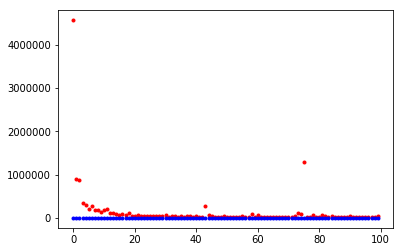

In [17]:
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

In [18]:
modelPred = model.predict(x_test)
end = time.time() - start
print(round(end,4))
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

2343.8812


228.91560211555066

In [19]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 25000.000, 예상가격: 25015.639
실제가격: 20900.000, 예상가격: 20785.254
실제가격: 35700.000, 예상가격: 35268.984
실제가격: 29250.000, 예상가격: 29113.027
실제가격: 5800.000, 예상가격: 5796.831
실제가격: 9500.000, 예상가격: 9376.754
실제가격: 15400.000, 예상가격: 15240.707
실제가격: 6300.000, 예상가격: 6252.543
실제가격: 20100.000, 예상가격: 19907.744
실제가격: 41500.000, 예상가격: 41287.551


In [22]:
model = load_model('./model/97-11597.8062.hdf5')

In [23]:
modelPred = model.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

113.2476758205423

In [24]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, round(prediction)))

실제가격: 25000.000, 예상가격: 25081.000
실제가격: 20900.000, 예상가격: 20922.000
실제가격: 35700.000, 예상가격: 35805.000
실제가격: 29250.000, 예상가격: 29295.000
실제가격: 5800.000, 예상가격: 5925.000
실제가격: 9500.000, 예상가격: 9483.000
실제가격: 15400.000, 예상가격: 15380.000
실제가격: 6300.000, 예상가격: 6371.000
실제가격: 20100.000, 예상가격: 20077.000
실제가격: 41500.000, 예상가격: 41406.000


Train on 2593458 samples, validate on 1728972 samples
Epoch 1/10
2593458/2593458 [==============================] - 22s 8us/step - loss: 73712930.3306 - acc: 2.3559e-04 - val_loss: 5061312.9532 - val_acc: 4.4362e-04

Epoch 00001: val_loss improved from inf to 5061312.95319, saving model to ./model/01-5061312.9532.hdf5
Epoch 2/10
2593458/2593458 [==============================] - 23s 9us/step - loss: 2630065.1739 - acc: 5.6797e-04 - val_loss: 1109839.6191 - val_acc: 9.4276e-04

Epoch 00002: val_loss improved from 5061312.95319 to 1109839.61908, saving model to ./model/02-1109839.6191.hdf5
Epoch 3/10
2593458/2593458 [==============================] - 23s 9us/step - loss: 1021264.4194 - acc: 7.5652e-04 - val_loss: 903191.5148 - val_acc: 3.2563e-04

Epoch 00003: val_loss improved from 1109839.61908 to 903191.51484, saving model to ./model/03-903191.5148.hdf5
Epoch 4/10
2593458/2593458 [==============================] - 23s 9us/step - loss: 765057.4359 - acc: 8.3595e-04 - val_loss: 425375.9

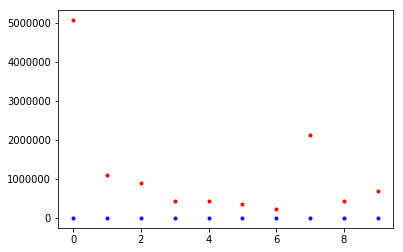

279.3059


807.9923525102294

In [26]:
model = Sequential()
model.add(Dense(140, input_dim=14, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

start = time.time()
history = model.fit(x_train, y_train, validation_split=0.4, epochs=10, batch_size=1000, callbacks=[checkpointer])
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

modelPred = model.predict(x_test)
end = time.time() - start
print(round(end,4))
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE